In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Informer-Like

Training: 100%|██████████| 50/50 [00:10<00:00,  4.60epoch/s, epoch=50, train_loss=0.0140, lr=1.00e-03]


Validation Forecast Error Metrics:
  MSE   = 0.012104
  RMSE  = 0.110018
  MAE   = 0.088646


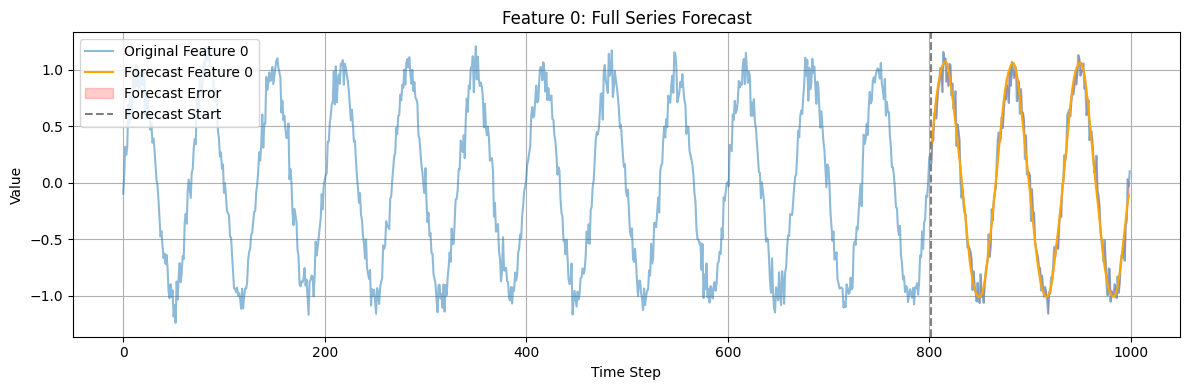

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer


# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 128,
    "nhead": 8,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

from foreblocks.tf.embeddings import RoPEPositionalEncoding

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    att_type="standard",  # Use probabilistic sparse attention
    use_moe=False,  # Use Mixture of Experts
    custom_norm="rms",
    # pos_encoder=RoPEPositionalEncoding(
    #     d_model=model_params.get("input_processor_output_size", 1),
    #     max_len=model_params.get("seq_len", 50),
    # ),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    informer_like=True,  # Use Informer-like architecture,
    att_type="standard",  # Use probabilistic sparse attention
    custom_norm="rms",
    use_moe=False,  # Use Mixture of Experts
)

total_epochs = 50  # Total number of epochs for training
def scheduled_sampling_fn(epoch):
    # Use a linear decay from 1.0 to 0.0 over the epochs
    tf_ratio = max(0.0, 0.95 - (epoch / total_epochs))

    return tf_ratio

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="informer-like",  # Use Informer-like architecture
    scheduled_sampling_fn=scheduled_sampling_fn,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]
# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader, epochs=total_epochs)
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
metrics = trainer.metrics(X_val, Y_val)



# PatchTST

Training: 100%|██████████| 50/50 [00:06<00:00,  7.85epoch/s, epoch=50, train_loss=0.0199, lr=1.00e-03]



Validation Forecast Error Metrics:
  MSE   = 0.011672
  RMSE  = 0.108038
  MAE   = 0.087195
{'mse': 0.011672242544591427, 'rmse': 0.10803814977407455, 'mae': 0.08719474077224731}


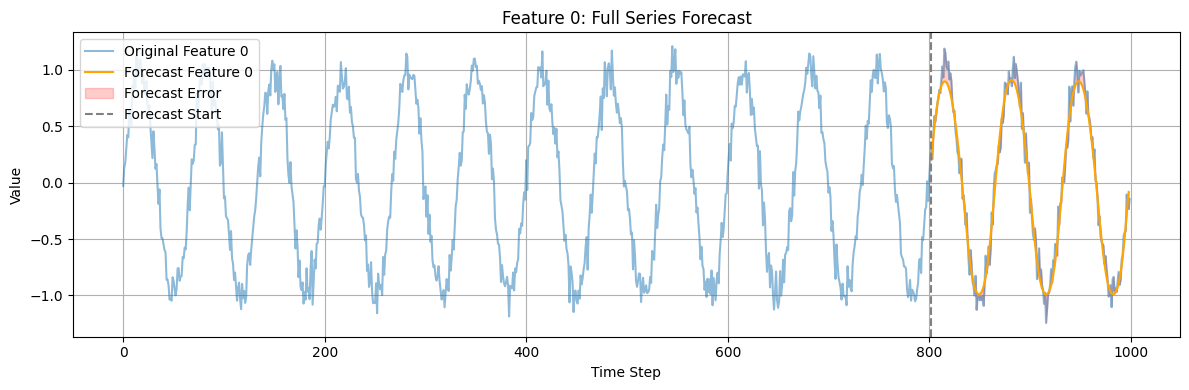

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel  # this is your BaseForecastingModel
from foreblocks import Trainer

# ⬇️ Import the custom PatchTST head we just built with your MultiAttention stack
from foreblocks.blocks.heads import PatchTSTHeadCustom

# -----------------------
# Params (same as before)
# -----------------------
input_size  = 1
output_size = 1
seq_len     = 50
target_len  = 10
total_len   = 1000
total_epochs = 50

model_params = {
    "seq_len": seq_len,
    "target_len": target_len,
    "total_len": total_len,
    "input_size": input_size,
    "output_size": output_size,
}

def scheduled_sampling_fn(epoch):
    # not used in encoder-only, but harmless to keep around
    tf_ratio = max(0.0, 0.95 - (epoch / total_epochs))
    return tf_ratio

# -----------------------
# Build PatchTST head
# -----------------------
patch_head = PatchTSTHeadCustom(
    pred_len=target_len,
    patch_len=16,
    stride=8,
    d_model=256,
    n_heads=8,
    n_layers=3,
    dim_feedforward=512,
    dropout=0.1,
    activation="gelu",
    att_type="standard",
    freq_modes=32,
    norm_strategy="pre_norm",
    custom_norm="rms",
    use_swiglu=True,
    use_moe=False,          # flip on if you want MoE in the token encoder
    num_experts=8,
    top_k=2,
    moe_capacity_factor=1.25,
    layer_norm_eps=1e-5,
    use_final_norm=True,
    pooling="mean",         # used only when output_mode="pooled"
    use_cls_token=False,
    head_hidden=256,        # 0 = linear; small MLP often helps
    output_mode="nonpool_attn",  # "pooled" | "nonpool_linear" | "nonpool_attn"
    in_channels=input_size,
    out_channels=output_size,    # keep same to predict 1 channel
    max_patches=10_000,
)

# -----------------------
# Encoder-only model
# -----------------------
model = ForecastingModel(
    encoder=None,
    decoder=patch_head,                 # <— call the head directly
    target_len=target_len,
    forecasting_strategy="direct",      # <— IMPORTANT
    model_type="encoder_only",          # label only; not used by "direct"
    output_size=output_size,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
)

# -----------------------
# Data (unchanged)
# -----------------------
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # [T, 1]

def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val     = X[train_size:], Y[train_size:]

from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)

# -----------------------
# Train / eval (unchanged)
# -----------------------
trainer = Trainer(
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    criterion=nn.MSELoss(),
)

history = trainer.train(train_loader, epochs=total_epochs)
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
metrics = trainer.metrics(X_val, Y_val)
print(metrics)


# LSTM

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training:  88%|████████▊ | 88/100 [00:02<00:00, 29.56epoch/s, epoch=88, train_loss=0.0104, lr=1.00e-03]


KeyboardInterrupt: 

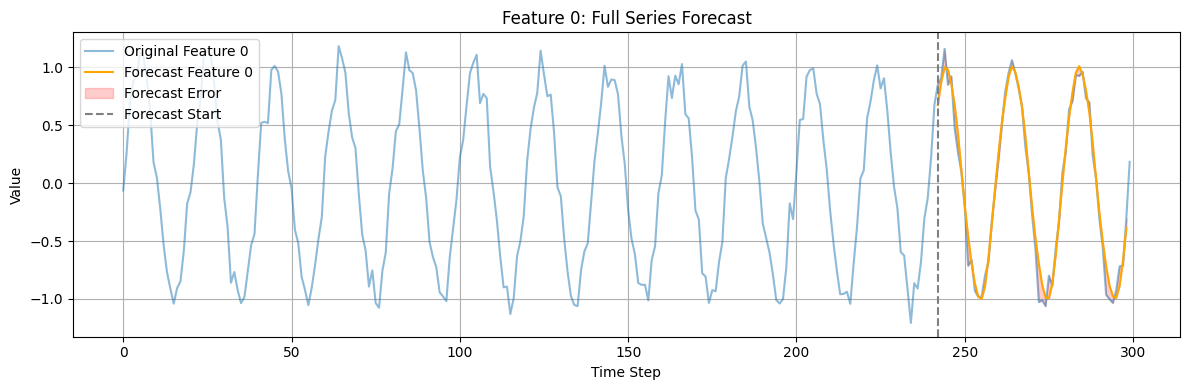

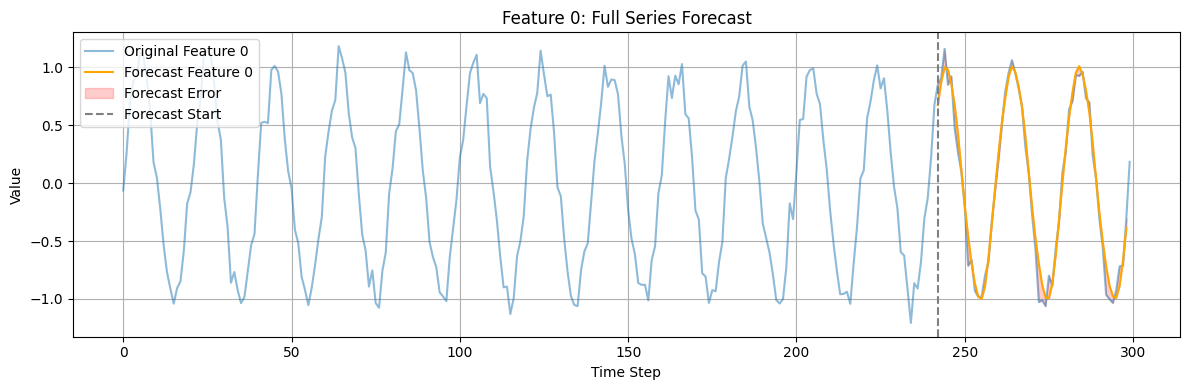

In [ ]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
#trainer.set_config('num_epochs', 200)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




Training:   2%|▏         | 2/100 [00:01<01:04,  1.52epoch/s, epoch=2, train_loss=0.5791, lr=1.00e-03] 


KeyboardInterrupt: 

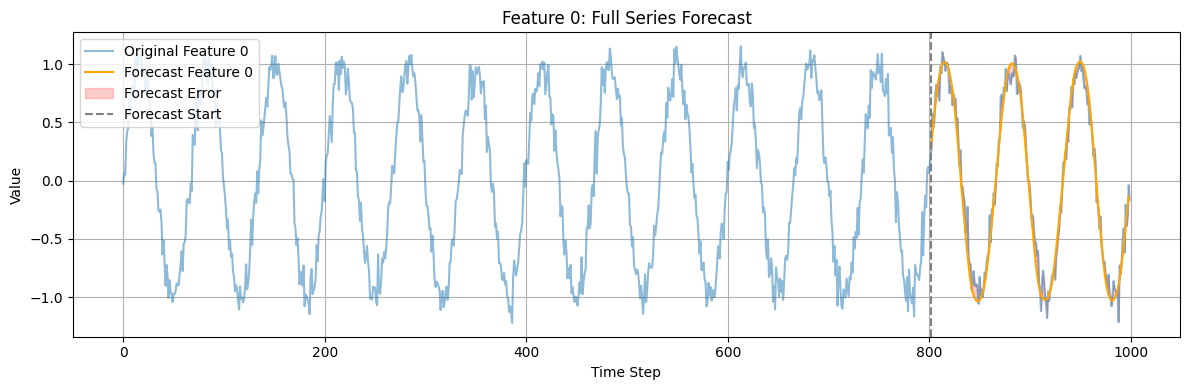

In [ ]:
fig = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)